### Стартер 5
# 🏬 DWthon 5.0 - прогнозирование еженедельных продаж на год вперед 🏬

![](./images/ecommerce.png)

Последний стартер перед Тобой, но помни, что это не последний шаг, который можешь сделать. Это всего лишь руководство для тех, кто нуждается в поддержке. Цель соревнований - попробовать все, что здесь есть ;), но общая цель - развитие :) Поэтому есть стартеры, которые нужно делать только с пониманием и иметь какой-то минимальный опыт, позволяющий разгоняться.


Что происходит в этом стартере?

1. Я сделал то, чего никогда не делаю 😱 Я удалил строки 😱 Не считай это чем-то достойным повторения в каждой ситуации, наоборот, лучше этого не делать, но стоит иметь в виду, что бывают ситуации, когда можно это сделать, если улучшится результат и этих строк мало.

2. Я логарифмирую целевую переменную. Смотри, что получилось :)

## 📥 Импортируем нужные библиотеки

In [2]:
# подключаем библиотеку функций для оптимизации работы с моделями
# https://github.com/alukyantsev/magic_ds/
from magic_ds_20220217 import *
from magic_ds_20220217.ml import *
from magic_ds_20220217.ml.sklearnex import *

# подключаем модели
from magic_ds_20220217.ml.model_ensemble import *
from magic_ds_20220217.ml.model_boost import *

%matplotlib inline

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
from sklearn.model_selection import cross_val_score
plt.rcParams["figure.figsize"] = (15, 5)

## 🗃️  Загружаем данные


In [5]:
df_sales_train = pd.read_hdf("./input/sales_train.h5")
df_sales_test = pd.read_hdf("./input/sales_test.h5")

df_sales_train["date"] = pd.to_datetime(df_sales_train["date"])

df_sales_train = df_sales_train.sort_values(by=["store", "dept", "date"])
df_sales_test["date"] = pd.to_datetime(df_sales_test["date"])

df_sales_train.head(10)

,id,weekly_sales,store,dept,date,is_holiday
79017,79017,20094.19,1,1,2010-01-10,False
81351,81351,57258.43,1,1,2010-02-04,False
256391,256391,16333.14,1,1,2010-02-07,False
115305,115305,41595.55,1,1,2010-02-19,False
351187,351187,19403.54,1,1,2010-02-26,False
286688,286688,16241.78,1,1,2010-03-09,False
37947,37947,22517.56,1,1,2010-03-12,False
72620,72620,22136.64,1,1,2010-03-19,False
384329,384329,26229.21,1,1,2010-03-26,False
294658,294658,17558.09,1,1,2010-04-06,False


Воспользуемся предыдущим кодом.

In [6]:
def feature_engineering(df):
    df["dayofweek"] = df["date"].dt.dayofweek
    df["dayofyear"] = df["date"].dt.dayofyear
    df["week"] = df["date"].dt.week
    df["month"] = df["date"].dt.month

    
    return df

df_sales_train = feature_engineering(df_sales_train)
df_sales_test = feature_engineering(df_sales_test)


df_store = df_sales_train[ ["store", "dept", "weekly_sales"] ].groupby(["store", "dept"]).agg(["mean", "std", "median", "size"])["weekly_sales"].reset_index()
df_store.head()


df_sales_train_ext = pd.merge(df_sales_train, df_store, on=["store", "dept"], how="left").fillna(-1)
df_sales_test_ext = pd.merge(df_sales_test, df_store, on=["store", "dept"], how="left").fillna(-1)
df_sales_train_ext.head()

,id,weekly_sales,store,dept,date,is_holiday,dayofweek,dayofyear,week,month,mean,std,median,size
0,79017,20094.19,1,1,2010-01-10,False,6,10,1,1,22494.71,9784.87,18820.29,97
1,81351,57258.43,1,1,2010-02-04,False,3,35,5,2,22494.71,9784.87,18820.29,97
2,256391,16333.14,1,1,2010-02-07,False,6,38,5,2,22494.71,9784.87,18820.29,97
3,115305,41595.55,1,1,2010-02-19,False,4,50,7,2,22494.71,9784.87,18820.29,97
4,351187,19403.54,1,1,2010-02-26,False,4,57,8,2,22494.71,9784.87,18820.29,97


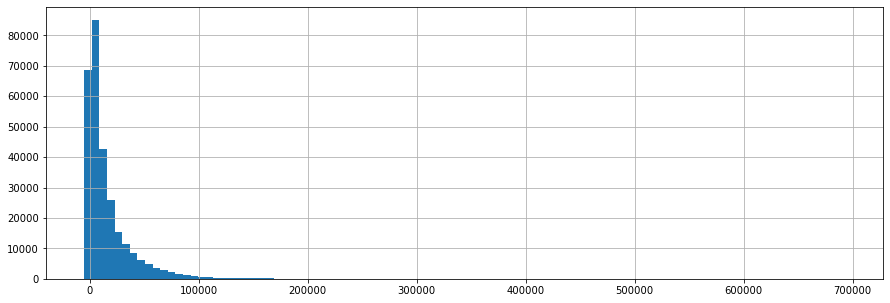

In [7]:
df_sales_train["weekly_sales"].hist(bins=100);

## ⚙️Подготовка `X`, `y`

У нас уже есть признаки, теперь мы можем подготовить нашу матрицу.

In [8]:
feats = ["store", "dept", "is_holiday", "week", "mean", "std", "median", "size"]

X_train = df_sales_train_ext[ feats ].values
X_test = df_sales_test_ext[ feats ].values



y_train = df_sales_train_ext["weekly_sales"].values
X_train = X_train[ y_train > 0 ]
y_train = y_train[ y_train > 0 ]


y_train_log = np.log(y_train)

In [9]:
feats_df = ["id", "store", "dept", "is_holiday", "week", "mean", "std", "median", "size", "weekly_sales"]
df = pd.concat([df_sales_train_ext, df_sales_test_ext])[feats_df]
df.set_index('id', inplace=True)
df

,store,dept,is_holiday,week,mean,std,median,size,weekly_sales
id,,,,,,,,,
79017,1,1,False,1,22494.71,9784.87,18820.29,97.00,20094.19
81351,1,1,False,5,22494.71,9784.87,18820.29,97.00,57258.43
256391,1,1,False,5,22494.71,9784.87,18820.29,97.00,16333.14
115305,1,1,False,7,22494.71,9784.87,18820.29,97.00,41595.55
351187,1,1,False,8,22494.71,9784.87,18820.29,97.00,19403.54
...,...,...,...,...,...,...,...,...,...
421557,35,1,False,21,17688.74,7684.84,15274.03,97.00,NaN
421560,21,18,False,33,8158.44,11735.41,2839.27,69.00,NaN
421564,26,67,False,50,6522.00,2574.42,5529.77,97.00,NaN


In [10]:
gap_info(df)

Your selected dataframe has 9 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
weekly_sales,136481,32.40


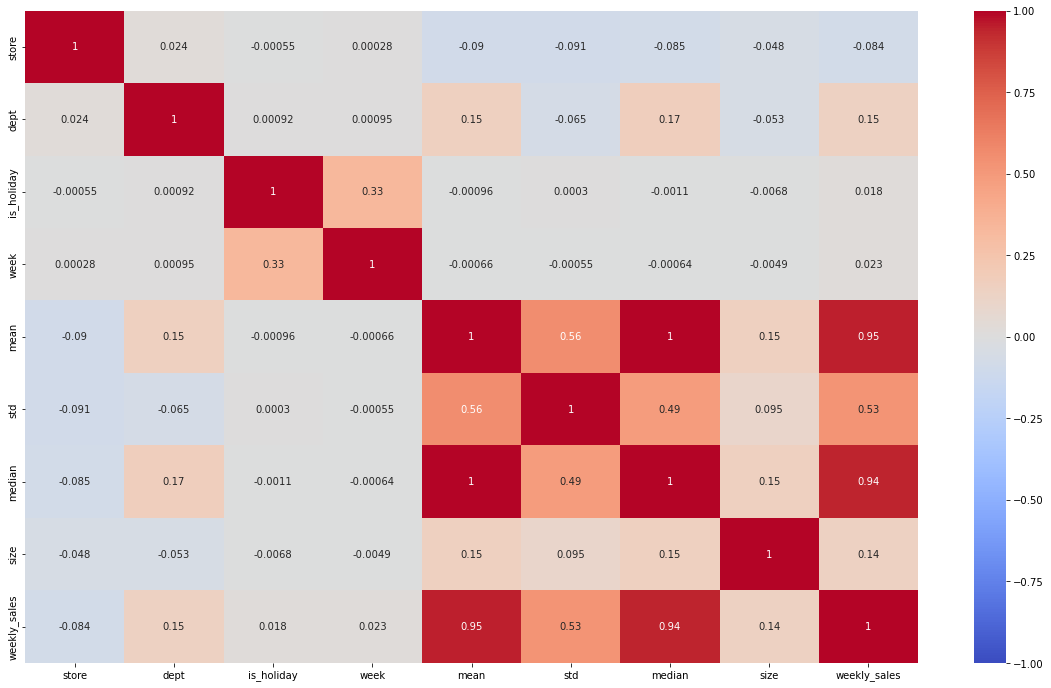

In [11]:
visualize_corr(df)

In [12]:
gap_negative(df)

0	- store
0	- dept
0	- week
875	- mean
466	- std
682	- median
303	- size
834	- weekly_sales


['mean', 'std', 'median', 'size', 'weekly_sales']

In [13]:
analyze_unique(df)

==================== store (45 unique) ====================
13    10474
10    10315
4     10272
1     10244
2     10238
24    10228
27    10225
34    10224
20    10214
6     10211
32    10202
19    10148
31    10142
28    10113
41    10088
11    10062
23    10050
14    10040
40    10017
15     9901
8      9895
39     9878
17     9864
18     9859
26     9854
25     9804
7      9762
12     9705
22     9688
45     9637
21     9582
35     9528
29     9455
16     9443
3      9036
5      8999
9      8867
38     7362
37     7206
44     7169
30     7156
42     6953
43     6751
33     6487
36     6222
Name: store, dtype: int64 

==================== dept (81 unique) ====================
1     6435
16    6435
92    6435
38    6435
40    6435
2     6435
82    6435
46    6435
95    6435
81    6435
79    6435
21    6435
90    6435
91    6435
14    6435
4     6435
13    6435
3     6435
10    6435
8     6435
7     6435
67    6435
11    6434
74    6430
17    6412
12    6409
42    6401
87    6391
25   

In [14]:
d = {}

d['original'] = split_df(
    df, 'weekly_sales', prc_train=85, prc_valid=15, prc_test=0,
    target_test_value=np.nan, random_state=42
)

d['log'] = split_df(
    df[df['weekly_sales'] > 0], 'weekly_sales', prc_train=85, prc_valid=15, prc_test=0,
    target_test_value=np.nan, random_state=42
)
d['log']['y_train'] = np.log(d['log']['y_train'])
d['log']['y_valid'] = np.log(d['log']['y_valid'])
d['log']['X_test'] = d['original']['X_test']

In [15]:
np.save('./d.npy', d)
#d = np.load('./d.npy', allow_pickle='TRUE').item()
split_dict_struct(d)

==================== Structure =====================

original -> X_train (242325, 8)
original -> X_valid (42764, 8)
original -> X_test (136481, 8)
original -> y_train (242325,)
original -> y_valid (42764,)

log -> X_train (241570, 8)
log -> X_valid (42631, 8)
log -> X_test (136481, 8)
log -> y_train (241570,)
log -> y_valid (42631,)


In [16]:
# выводим список топ колонок, влияющих на целевую переменную через eli5
model_eli5 = select_eli5(
    pd.concat([ d['original']['X_train'], d['original']['X_valid'] ]),
    pd.concat([ d['original']['y_train'], d['original']['y_valid'] ]),
    xgb.XGBRegressor(**param_XGBRegressor),
    scoring='neg_mean_absolute_error'
)

Weight,Feature
0.9204,mean
0.0274,std
0.0203,is_holiday
0.0128,median
0.0090,week
0.0062,dept
0.0033,size
0.0006,store


Weight,Feature
16506.6987 ± 29.5485,mean
532.5331 ± 10.6640,week
405.0521 ± 3.5927,median
384.6044 ± 6.4633,std
93.1761 ± 0.7451,dept
28.3279 ± 1.7442,is_holiday
16.1757 ± 1.3516,size
1.3614 ± 0.2409,store


In [33]:
# xgb.LGBMRegressor
estimator = lgb.LGBMRegressor
param_grid = locals()['params_' + estimator.__name__]
param_grid = {
    'max_depth':[9, 11, 13],
    'n_estimators':[500, 800, 1000],
    'min_child_weight':[5],
    'learning_rate':[0.1],
    'random_state': [42]
}
param_grid = {
    'max_depth':[13],
    'n_estimators':[1000],
    'min_child_weight':[5],
    'learning_rate':[0.1],
    'random_state': [42]
}
# param_grid = {
#     'max_depth':[2],
#     'n_estimators':[100],
#     'min_child_weight':[5],
#     'learning_rate':[0.1],
#     'random_state': [42]
# }
if gpu:
    param_grid = {
        **param_grid,
        **{ 'device': ['gpu'] }
    }

for i in tqdm([0]):
    d['log'][estimator.__name__] = model_fit(
        estimator, param_grid,
        d['log']['X_train'], d['log']['y_train'],
        d['log']['X_valid'], d['log']['y_valid'],
        d['log']['X_test'],
        result=3, scoring='neg_mean_absolute_error', learning_curves_dots=0
    )
eli5.explain_weights(d['log'][estimator.__name__]['model'], top=20)

  0%|          | 0/1 [00:00<?, ?it/s]

==================== Stage 1: train ====================

Best estimator: LGBMRegressor(max_depth=13, min_child_weight=5, n_estimators=1000,
              random_state=42)
Best train score: 0.242441 make_scorer(mean_absolute_error, greater_is_better=False) using {'learning_rate': 0.1, 'max_depth': 13, 'min_child_weight': 5, 'n_estimators': 1000, 'random_state': 42}

==================== Stage 2: valid ====================

Best valid score: 0.241916 using {'learning_rate': 0.1, 'max_depth': 13, 'min_child_weight': 5, 'n_estimators': 1000, 'random_state': 42}



100%|██████████| 1/1 [00:41<00:00, 41.26s/it]


Weight,Feature
0.9172,median
0.0385,mean
0.0239,week
0.0074,dept
0.0061,size
0.0038,std
0.0017,store
0.0014,is_holiday


In [34]:
np.save('./d.npy', d)
#d = np.load('./d.npy', allow_pickle='TRUE').item()
split_dict_struct(d)

==================== Structure =====================

original -> X_train (242325, 8)
original -> X_valid (42764, 8)
original -> X_test (136481, 8)
original -> y_train (242325,)
original -> y_valid (42764,)

log -> X_train (241570, 8)
log -> X_valid (42631, 8)
log -> X_test (136481, 8)
log -> y_train (241570,)
log -> y_valid (42631,)
log -> LGBMRegressor ()
log -> LGBMRegressor -> model ()
log -> LGBMRegressor -> y_pred (136481,)
log -> LGBMRegressor -> y_valid_pred (42631,)
log -> CatBoostRegressor ()
log -> CatBoostRegressor -> model ()
log -> CatBoostRegressor -> y_pred (136481,)
log -> CatBoostRegressor -> y_valid_pred (42631,)
log -> XGBRegressor ()
log -> XGBRegressor -> model ()
log -> XGBRegressor -> y_pred (136481,)
log -> XGBRegressor -> y_valid_pred (42631,)


In [35]:
df_sales_test["weekly_sales"] = np.exp(d['log']['LGBMRegressor']['y_pred'])
df_sales_test[ ["id", "weekly_sales"] ].to_csv("./output/gs_lgb_log.csv", index=False)

In [30]:
# xgb.CatBoostRegressor
estimator = ctb.CatBoostRegressor
param_grid = locals()['params_' + estimator.__name__]
param_grid = {
    'max_depth':[9, 12],
    'n_estimators':[500, 800],
    'learning_rate':[0.1],
    'random_state': [42],
    'verbose': [0]
}
# param_grid = {
#     'max_depth':[2],
#     'n_estimators':[100],
#     'learning_rate':[0.1],
#     'random_state': [42],
#     'verbose': [0]
# }
if gpu:
    param_grid = {
        **param_grid,
        **{ 'task_type': ['GPU'] }
    }

for i in tqdm([0]):
    d['log'][estimator.__name__] = model_fit(
        estimator, param_grid,
        d['log']['X_train'], d['log']['y_train'],
        d['log']['X_valid'], d['log']['y_valid'],
        d['log']['X_test'],
        result=3, scoring='neg_mean_absolute_error', learning_curves_dots=0, n_jobs=(1 if gpu else 1)
    )
eli5.explain_weights(d['log'][estimator.__name__]['model'], top=20)

  0%|          | 0/1 [00:00<?, ?it/s]

==================== Stage 1: train ====================

Best estimator: <catboost.core.CatBoostRegressor object at 0x7fb21c20e460>
Best train score: 0.246187 make_scorer(mean_absolute_error, greater_is_better=False) using {'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 800, 'random_state': 42, 'verbose': 0}

==================== Stage 2: valid ====================

Best valid score: 0.243941 using {'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 800, 'random_state': 42, 'verbose': 0}



100%|██████████| 1/1 [18:00<00:00, 1080.30s/it]


Weight,Feature
0.3449,median
0.2302,week
0.1393,mean
0.1153,size
0.0828,dept
0.0492,std
0.0192,is_holiday
0.0190,store


In [31]:
np.save('./d.npy', d)
#d = np.load('./d.npy', allow_pickle='TRUE').item()
split_dict_struct(d)

==================== Structure =====================

original -> X_train (242325, 8)
original -> X_valid (42764, 8)
original -> X_test (136481, 8)
original -> y_train (242325,)
original -> y_valid (42764,)

log -> X_train (241570, 8)
log -> X_valid (42631, 8)
log -> X_test (136481, 8)
log -> y_train (241570,)
log -> y_valid (42631,)
log -> LGBMRegressor ()
log -> LGBMRegressor -> model ()
log -> LGBMRegressor -> y_pred (136481,)
log -> LGBMRegressor -> y_valid_pred (42631,)
log -> CatBoostRegressor ()
log -> CatBoostRegressor -> model ()
log -> CatBoostRegressor -> y_pred (136481,)
log -> CatBoostRegressor -> y_valid_pred (42631,)
log -> XGBRegressor ()
log -> XGBRegressor -> model ()
log -> XGBRegressor -> y_pred (136481,)
log -> XGBRegressor -> y_valid_pred (42631,)


In [32]:
df_sales_test["weekly_sales"] = np.exp(d['log']['CatBoostRegressor']['y_pred'])
df_sales_test[ ["id", "weekly_sales"] ].to_csv("./output/gs_ctb_log.csv", index=False)

In [42]:
# xgb.XGBRegressor
estimator = xgb.XGBRegressor
param_grid = {
    'max_depth':[10, 13],
    'n_estimators':[500, 700, 1000],
    'learning_rate':[0.1],
    'random_state': [42]
}
param_grid = {
    'max_depth':[13],
    'n_estimators':[500],
    'learning_rate':[0.1],
    'random_state': [42]
}
# param_grid = {
#     'max_depth':[2],
#     'n_estimators':[100],
#     'learning_rate':[0.1],
#     'random_state': [42]
# }
if gpu:
    param_grid = {
        **param_grid,
        **{ 'tree_method': ['gpu_hist'], 'gpu_id': [0] }
    }

for i in tqdm([0]):
    d['log'][estimator.__name__] = model_fit(
        estimator, param_grid,
        d['log']['X_train'], d['log']['y_train'],
        d['log']['X_valid'], d['log']['y_valid'],
        d['log']['X_test'],
        result=3, scoring='neg_mean_absolute_error', learning_curves_dots=0
    )
eli5.explain_weights(d['log'][estimator.__name__]['model'], top=20)

  0%|          | 0/1 [00:00<?, ?it/s]

==================== Stage 1: train ====================

Best estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=13,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
Best train score: 0.263225 make_scorer(mean_absolute_error, greater_is_better=False) using {'learning_rate': 0.1, 'max_depth': 13, 'n_estimators': 500, 'random_state': 42}

==================== Stage 2: valid ====================

Best valid score: 0.263318 using {'learning_rate': 0.1, 'max_depth': 13, 'n_estimators': 500, 'random_state': 42}



100%|██████████| 1/1 [19:07<00:00, 1147.84s/it]


Weight,Feature
0.9581,median
0.0145,mean
0.0100,size
0.0054,week
0.0041,is_holiday
0.0034,dept
0.0032,std
0.0013,store


In [43]:
np.save('./d.npy', d)
#d = np.load('./d.npy', allow_pickle='TRUE').item()
split_dict_struct(d)

==================== Structure =====================

original -> X_train (242325, 8)
original -> X_valid (42764, 8)
original -> X_test (136481, 8)
original -> y_train (242325,)
original -> y_valid (42764,)

log -> X_train (241570, 8)
log -> X_valid (42631, 8)
log -> X_test (136481, 8)
log -> y_train (241570,)
log -> y_valid (42631,)
log -> LGBMRegressor ()
log -> LGBMRegressor -> model ()
log -> LGBMRegressor -> y_pred (136481,)
log -> LGBMRegressor -> y_valid_pred (42631,)
log -> CatBoostRegressor ()
log -> CatBoostRegressor -> model ()
log -> CatBoostRegressor -> y_pred (136481,)
log -> CatBoostRegressor -> y_valid_pred (42631,)
log -> XGBRegressor ()
log -> XGBRegressor -> model ()
log -> XGBRegressor -> y_pred (136481,)
log -> XGBRegressor -> y_valid_pred (42631,)


In [44]:
df_sales_test["weekly_sales"] = np.exp(d['log']['XGBRegressor']['y_pred'])
df_sales_test[ ["id", "weekly_sales"] ].to_csv("./output/gs_xgb_log.csv", index=False)

Обрати внимание, что `y_train` также имеет отрицательные значения. Логарифм с этим не справляется, поэтому мы удалили строки, где продажи отрицательные (кстати, интересно, почему продажи были отрицательными?). К счастью, таких строк было немного.

## Обучаем модель

Обучим модель прогнозированию.

⌛️⌛️⌛️ Само обучение займет «немного» времени, просто подожди минуту или дольше. Модель учится 🦾.

In [ ]:
# model = xgb.XGBRegressor(max_depth=10, n_estimators=500, learning_rate=0.1, random_state=42)
# model.fit(X_train, y_train_log)

## 🌎 Submit

In [ ]:
# !mkdir -p ./output

In [ ]:
# df_sales_test["weekly_sales"] = np.exp(model.predict(X_test))

# df_sales_test[ ["id", "weekly_sales"] ].to_csv("../output/simple_xgb_log.csv", index=False)

## Что дальше ;)

Стоит больше заниматься **feature engineering**. Больше экспериментов.

Экспериментируй, но избегай «черных дыр». Одним словом, применяй на практике правило 80 на 20.

In [ ]:
## YOUR CODE HERE

## 🤝🗣️ Совместное обсуждение и обмен опытом 💬
Соревнование соревнованием, но во всем этом есть нечто большее, чем победа...

👉 *сотрудничество, общение, творческое и критическое мышление* - это ценности и навыки, о которых стоит заботиться

Прежде всего, речь идет о том, чтобы как можно больше учиться и поддерживать друг друга. Помни о здоровой конкуренции и взаимной помощи
🤝 

Для проведения конкурса в Kaggle мы создали отдельные каналы:
- [#dwthon_general](https://dataworkshop-ru.slack.com/archives/C02NRMNLE2D) - **общий канал**
- [#dwthon_ideas](https://dataworkshop-ru.slack.com/archives/C02N6CBK1CN) - **канал, где можно делиться мыслями и идеями**
- [#dwthon_questions](https://dataworkshop-ru.slack.com/archives/C02N6C69G3Y) - **канал, где можно задавать вопросы**


##  Некоторые факты о `DWClub`:
- Участники `DW Club` имеют доступ к материалам 24/7
- Этот интенсив - уже очередной материал для `DW Club`, и с каждым месяцем их количество будет только увеличиваться.
- Участникам `DW Club` предоставляются более выгодные условия покупки платных курсов и т.д.

Узнай больше [нажав на ссылку](https://dataworkshop.ru/data-science/dw-club).